<a href="https://colab.research.google.com/github/miohana/time-series-sales-transactions/blob/master/time_series_sales_transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sales Forecasting Example with Multiple Time Series

This is an example of time series implemented for sales prediction, using [Mario Filho's tutorial](https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/).

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('/content/sample_data/Sales_Transactions_Dataset_Weekly.csv')
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,9,3,5,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,8,12,6,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,5,5,8,7,11,7,12,6,6,5,11,8,9


In [3]:
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Week', 'Product_Code'])
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [4]:
melt2 = melt.copy()
melt2['Last_Week_Sales'] = melt2.groupby(['Product_Code'])['Sales'].shift()
melt2['Last_Week_Diff'] = melt2.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt2 = melt2.dropna()
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


In [0]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [6]:
mean_error = []
for week in range(40,52):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]

    p = val['Last_Week_Sales'].values

    error = rmsle(val['Sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.51952
Week 41 - Error 0.51691
Week 42 - Error 0.51026
Week 43 - Error 0.50792
Week 44 - Error 0.53409
Week 45 - Error 0.52347
Week 46 - Error 0.50018
Week 47 - Error 0.49138
Week 48 - Error 0.50585
Week 49 - Error 0.50547
Week 50 - Error 0.52220
Week 51 - Error 0.55242
Mean Error = 0.51581


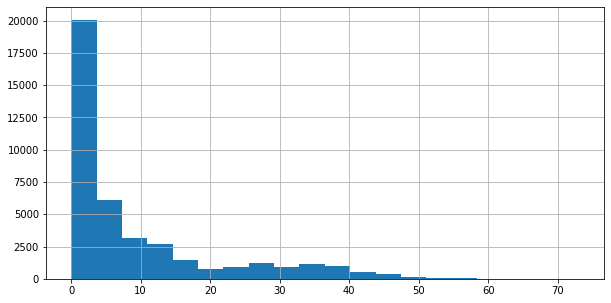

In [7]:
melt2['Sales'].hist(bins=20, figsize=(10,5))

In [8]:
mean_error = []
for week in range(40,52):
    train = melt2[melt2['Week'] < week]
    val = melt2[melt2['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.46242
Week 41 - Error 0.45964
Week 42 - Error 0.46166
Week 43 - Error 0.46655
Week 44 - Error 0.47122
Week 45 - Error 0.43100
Week 46 - Error 0.47183
Week 47 - Error 0.44945
Week 48 - Error 0.46080
Week 49 - Error 0.44696
Week 50 - Error 0.47465
Week 51 - Error 0.48651
Mean Error = 0.46189


In [9]:
melt3 = melt.copy()
melt3['Last_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift()
melt3['Last_Week_Diff'] = melt3.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt3['Last-1_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift(2)
melt3['Last-1_Week_Diff'] = melt3.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt3 = melt3.dropna()
melt3.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


In [10]:
mean_error = []
for week in range(40,52):
    train = melt3[melt3['Week'] < week]
    val = melt3[melt3['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.44389
Week 41 - Error 0.45812
Week 42 - Error 0.43652
Week 43 - Error 0.44033
Week 44 - Error 0.46318
Week 45 - Error 0.42361
Week 46 - Error 0.45752
Week 47 - Error 0.44533
Week 48 - Error 0.44598
Week 49 - Error 0.43538
Week 50 - Error 0.47349
Week 51 - Error 0.46487
Mean Error = 0.44902


In [11]:
melt4 = melt.copy()
melt4['Last_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Last_Week_Diff'] = melt4.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt4['Last-1_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Last-1_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt4['Last-2_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Last-2_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
melt4 = melt4.dropna()
melt4.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0


In [12]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.43096
Week 41 - Error 0.43894
Week 42 - Error 0.42754
Week 43 - Error 0.41965
Week 44 - Error 0.44807
Week 45 - Error 0.40729
Week 46 - Error 0.43950
Week 47 - Error 0.43334
Week 48 - Error 0.43856
Week 49 - Error 0.43049
Week 50 - Error 0.45920
Week 51 - Error 0.45356
Mean Error = 0.43559


##Changing the loss function

In [13]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))

    p = np.expm1(mdl.predict(xts))

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.41695
Week 41 - Error 0.42215
Week 42 - Error 0.41215
Week 43 - Error 0.40363
Week 44 - Error 0.43325
Week 45 - Error 0.39732
Week 46 - Error 0.42607
Week 47 - Error 0.41179
Week 48 - Error 0.43027
Week 49 - Error 0.43740
Week 50 - Error 0.44605
Week 51 - Error 0.47260
Mean Error = 0.42580


##A better model

In [14]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]

    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values

    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))

    p = np.expm1(mdl.predict(xts))

    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.40811
Week 41 - Error 0.39795
Week 42 - Error 0.39533
Week 43 - Error 0.39488
Week 44 - Error 0.42019
Week 45 - Error 0.37675
Week 46 - Error 0.40386
Week 47 - Error 0.38683
Week 48 - Error 0.39838
Week 49 - Error 0.40750
Week 50 - Error 0.42086
Week 51 - Error 0.45202
Mean Error = 0.40522


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


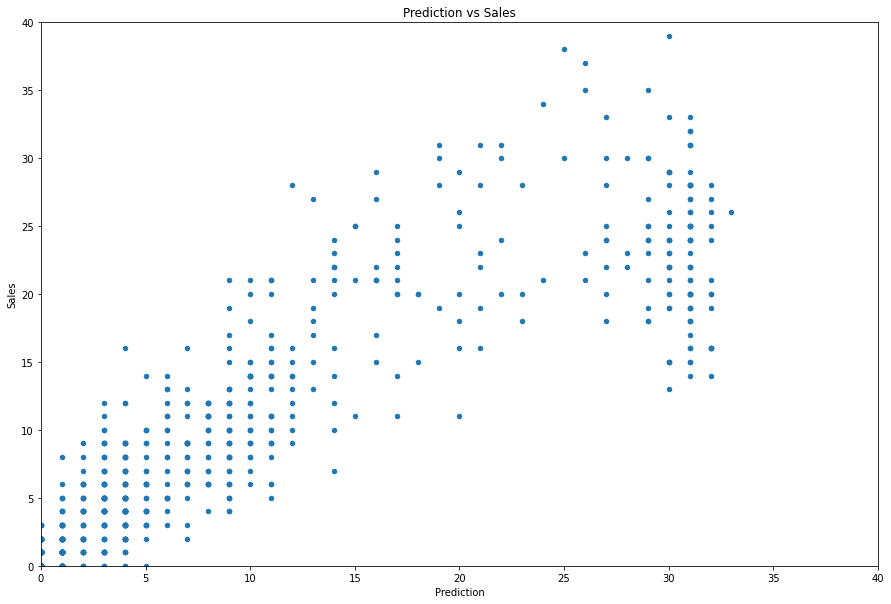

In [15]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Sales', figsize=(15,10), title='Prediction vs Sales', 
                 ylim=(0,40), xlim=(0,40))